### Ứng dụng KMeans clustering để phát hiện quả chín trong ảnh

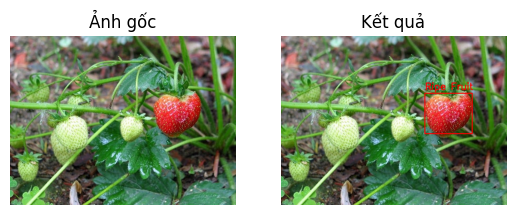

In [2]:
import cv2
import os
import time
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from random import randint, uniform

# kmeans implementation with k-means++ initialization
def kmeans(data, k, max_iterations=100, tolerance=1e-4):
    """
    Performs K-Means clustering on the given data with k-means++ initialization.

    Args:
        data (numpy.ndarray): Input data points.
        k (int): Number of clusters.
        max_iterations (int, optional): Maximum number of iterations. Default is 100.
        tolerance (float, optional): Tolerance for convergence. Default is 1e-4.

    Returns:
        numpy.ndarray: Cluster assignments for each data point.
        numpy.ndarray: Coordinates of the final cluster centroids.
    """
    # Initialize first centroid randomly
    centroids = [data[randint(0, data.shape[0] - 1)]]

    # Initialize other centroids using k-means++ initialization
    for _ in range(k - 1):
        distances = np.sqrt(((data - np.array(centroids)[:, np.newaxis])**2).sum(axis=2))
        min_distances = np.min(distances, axis=0)
        probabilities = min_distances / min_distances.sum()
        centroids.append(data[np.random.choice(data.shape[0], p=probabilities)])

    centroids = np.array(centroids)

    for _ in range(max_iterations):
        # Assign each data point to the closest centroid
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        cluster_assignments = np.argmin(distances, axis=0)

        # Update centroids
        new_centroids = np.array([data[cluster_assignments == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.abs(centroids - new_centroids).sum() < tolerance:
            break

        centroids = new_centroids

    return cluster_assignments, centroids

def detect_ripe_fruits(image):
    # Convert image to RGB color space
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = rgb_image.reshape((-1, 3))
    # Convert to float32
    pixel_values = np.float32(pixel_values)
    # Apply K-Means clustering
    num_clusters = 6
    labels, centers = kmeans(pixel_values, num_clusters)
    # Convert centers back to uint8
    centers = np.uint8(centers)
    # Create a new image by mapping each pixel to its corresponding cluster center
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(rgb_image.shape)
    # Create a mask for red color
    red_mask = cv2.inRange(segmented_image, (160, 0, 0), (255, 100, 100))
    # Find contours in the red mask
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Remove small contours
    def remove_small_boxes(contours, min_area=1000):
        filtered_contours = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > min_area:
                filtered_contours.append(cnt)
        return filtered_contours

    contours = remove_small_boxes(contours, min_area=1500)

    # Merge nearby bounding boxes
    def merge_nearby_boxes(boxes, max_distance=10):
      merged_boxes = []
      for box in boxes:
          x, y, w, h = box
          merged = False
          for i, merged_box in enumerate(merged_boxes):
              mx, my, mw, mh = merged_box
              if abs(x - mx) < max_distance or abs(x + w - (mx + mw)) < max_distance or abs(y - my) < max_distance or abs(y + h - (my + mh)) < max_distance:
                  x1 = min(x, mx)
                  y1 = min(y, my)
                  x2 = max(x + w, mx + mw)
                  y2 = max(y + h, my + mh)
                  merged_boxes[i] = [x1, y1, x2 - x1, y2 - y1]
                  merged = True
                  break
          if not merged:
              merged_boxes.append([x, y, w, h])
      return merged_boxes

    boxes = [cv2.boundingRect(cnt) for cnt in contours]
    merged_boxes = merge_nearby_boxes(boxes, max_distance=10)

    # Remove inner bounding boxes
    def remove_inner_boxes(boxes):
        outer_boxes = []
        for box in boxes:
            x, y, w, h = box
            is_inner = False
            for outer_box in outer_boxes:
                ox, oy, ow, oh = outer_box
                if x >= ox and x + w <= ox + ow and y >= oy and y + h <= oy + oh:
                    is_inner = True
                    break
            if not is_inner:
                outer_boxes.append(box)
        return outer_boxes


    final_boxes = remove_inner_boxes(merged_boxes)

    # Draw bounding boxes around the detected ripe fruits
    result_image = rgb_image.copy()
    for box in final_boxes:
        x, y, w, h = box
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(result_image, 'Ripe Fruit', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

    return result_image

if __name__ == "__main__":
    image = cv2.imread('./image/ripe5.jpeg')
    # Detect ripe fruits
    result = detect_ripe_fruits(image)
    # Display the result
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh gốc')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title('Kết quả')
    plt.axis('off')
    plt.show()

In [5]:
import os
import cv2

# Read image from folder and detect ripe fruits in the image and save the result in the result folder
def detect_ripe_fruits_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for filename in os.listdir(input_folder):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image = cv2.imread(os.path.join(input_folder, filename))
            result = detect_ripe_fruits(image)
            # Ghep anh goc va anh ket qua vao 1 anh, ben trai la anh goc, ben phai la anh ket qua
            result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
            combined = cv2.hconcat([image, result])
            cv2.imwrite(os.path.join(output_folder, filename), combined)



detect_ripe_fruits_in_folder('./image', './result')

print('Done!')
                    